In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
!{sys.executable} -m pip install MotionClouds

# Computational model figure
## Note : 
NPG palettes available at https://nanx.me/ggsci/reference/pal_npg.html

### Imports

In [3]:
import numpy as np
from scipy.special import i0 as I0

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec
from mpl_toolkits.mplot3d import axes3d

import MotionClouds as mc

### Params

In [4]:
N_X, N_Y = 256, 256 # MotionClouds texture size (px)

n_e = 360 # number of excitatory nodes in a ring
n_i = n_e // 4 # number of inhibitory nodes in a ring

e_radius = 1 # radius of the excitatory ring
i_radius = .8 # radius of the inhibitory ring

e_color = r'#E64B35'  # excitatory color
i_color = r'#3C5488'  # inhibitory color

s_mult = 8 # size gain, relative to node coordinate
ring_spacing = 2. # spacing between the two rings

plot_idxs = [15, 230, 80, 130] # indices for the neurons to plot
pops = ['L1', 'L1', 'L2', 'L2'] # population to which the idxs belong
cmap = plt.cm.magma(np.linspace(.3, .8, len(plot_idxs))) # color of the neurons

save = True # save the files ?
dpi = 250 # saving dpi

### Coordinates

In [5]:
rad = lambda n, rad : np.array([rad * np.cos(np.arange(0,n) * 2 * np.pi / n),
                                rad * np.sin(np.arange(0,n) * 2 * np.pi / n)])
e_xs, e_ys = rad(n_e, e_radius)
i_xs, i_ys = rad(n_i, i_radius)
lab_xs, lab_ys = rad(n_e, e_radius + .2 * e_radius)
extra_ys = np.linspace(.8, .37, len(plot_idxs))

### MotionClouds texture generation

In [6]:
def generate_cloud(theta, b_theta, sf_0,
                   N_X, N_Y,
                   seed, contrast=1):
    fx, fy, ft = mc.get_grids(N_X, N_Y, 1)

    mc_i = mc.envelope_gabor(fx, fy, ft,
                             V_X=0., V_Y=0., B_V=0.,
                             sf_0=sf_0, B_sf=sf_0,
                             theta=theta, B_theta=b_theta)

    im_ = mc.rectif(mc.random_cloud(mc_i, seed=seed),
                    contrast=contrast)
    return im_[:, :, 0]

### Fake data generation

In [7]:
def gen_raster(trials = 30, seed0 = 0) :
    r_array= []
    #np.random.seed(seed0)
    for t in range(trials) :
        trial = np.concatenate([np.random.uniform(-.1,.05, np.random.randint(2,8)),
                                np.random.uniform(.05, .10, np.random.randint(10,15)),
                                np.random.uniform(.10, .3, np.random.randint(15,35)),
                                np.random.uniform(.3, .45, np.random.randint(2,8))])
        r_array.append(trial)
    return np.asarray(r_array)

def gen_tc(seed = 0) :
    ''' Von Mises : kappa spread, mu location, I0 Bessel order 0
        fmax firing rate at pref ori, bsl min firing rate '''  
    np.random.seed(seed)
    x = np.linspace(0, np.pi, 200)
    bsl = np.random.uniform(.1, 5.)
    kappa = np.random.uniform(2., 8.)
    mu = np.random.uniform(np.pi/3, 2*np.pi/3)
    fmax = np.random.uniform(20, 30)
    return  bsl + (np.exp((kappa)*np.cos((x-mu)))/(2*np.pi*I0(kappa))) * fmax

### Matplotlib functions

In [8]:
def recurrent_connect(idx=180, n_arrows=40, i0_arrows=5, step_arrows=3, color=e_color,
                      xs=e_xs, ys=e_ys, yfrom_rectif = 0., yto_rectif=-.03):
    style = "Simple,tail_width=0.2,head_width=2,head_length=2"
    kw = dict(arrowstyle=style, edgecolor=color)
    alphas = 1 / np.exp(np.linspace(0., 2.5*np.e, n_arrows))
    lspace = np.linspace(i0_arrows, n_arrows, n_arrows // step_arrows, dtype=int)
    
    for i0, x in enumerate(lspace):
        arr = patches.FancyArrowPatch((xs[idx], ys[idx]+ yfrom_rectif) ,
                                      (xs[idx+x], ys[idx+x] + yto_rectif),
                                      facecolor='none',
                                      connectionstyle='arc3, rad = %.2f' %  .75,
                                      alpha=alphas[i0],
                                      **kw)
        ax.add_patch(arr)
    
    for i0, x in enumerate(-lspace) :
        arr = patches.FancyArrowPatch((xs[idx], ys[idx]+ yfrom_rectif ),
                                      (xs[idx+x], ys[idx+x] + yto_rectif),
                                      facecolor='none',
                                      connectionstyle='arc3, rad = %.2f' % -.75 ,
                                      alpha=alphas[i0],
                                      **kw)
        ax.add_patch(arr)

In [9]:
def layer_connect(idx=180, n_arrows=40, i0_arrows=5, step_arrows=3, color=e_color,
                    xs=e_xs, ys=e_ys, xs2=i_xs, ys2=i_ys, mult_connect = 4,
                    yfrom_rectif = 0., yto_rectif=-.03,
                 do_zero = False):
    style = "Simple,tail_width=0.2,head_width=2,head_length=2"
    kw = dict(arrowstyle=style, edgecolor=color)
    alphas = 1 / np.exp(np.linspace(0., np.e, n_arrows))
    lspace = np.linspace(i0_arrows, n_arrows, n_arrows // step_arrows, dtype=int)
    
    for i0, x in enumerate(lspace):
        arr = patches.FancyArrowPatch((xs[idx], ys[idx]+ yfrom_rectif) ,
                                      (xs2[int(idx*mult_connect)+x], ys2[int(idx*mult_connect)+x] + yto_rectif),
                                      facecolor='none',
                                      connectionstyle='arc3, rad = %.2f' % .01,
                                      alpha=alphas[i0],
                                      **kw)
        ax.add_patch(arr)
    
    for i0, x in enumerate( -lspace) :
        arr = patches.FancyArrowPatch((xs[idx], ys[idx]+ yfrom_rectif),
                                      (xs2[int(idx*mult_connect)+x], ys2[int(idx*mult_connect)+x] + yto_rectif),
                                      facecolor='none',
                                      connectionstyle='arc3, rad = %.2f' % -.01,
                                      alpha=alphas[i0],
                                      **kw)
        ax.add_patch(arr)
        
    if do_zero : 
        arr = patches.FancyArrowPatch((xs[idx], ys[idx]+ yfrom_rectif),
                                      (xs2[int(idx*mult_connect)], ys2[int(idx*mult_connect)] + yto_rectif),
                                      facecolor='none',
                                      connectionstyle='arc3, rad = %.2f' % -.01,
                                      alpha=alphas[0],
                                      **kw)
        ax.add_patch(arr)

In [10]:
def forward_connect(idx=180, n_arrows=40, step_arrows=3, color=e_color, lw = .3,
                    xs=e_xs, ys=e_ys, xs2=i_xs, ys2=i_ys, mult_connect = 4,
                    add_idx = 10,  yto_rectif=-.03):
    lspace = np.arange(-n_arrows, n_arrows, step_arrows, dtype=int)
    
    for i0, x in enumerate(lspace):
        ax.plot((xs[idx+x], xs2[int(mult_connect*idx)+x+add_idx]),
                (ys[idx+x], ys2[int(mult_connect*idx)+x+add_idx]+yto_rectif),
                color=color, linestyle=(0, (5, 7)),
                linewidth=lw, zorder=-1)
        ax.arrow(xs2[int(mult_connect*idx)+x+add_idx],
                 ys2[int(mult_connect*idx)+x+add_idx]+yto_rectif,
                 0, .005,
                    color=color, linewidth=.1 * (-ys[idx+x]+np.abs(np.min(ys))),
                    head_width=.0075, zorder=-1)

### Figure

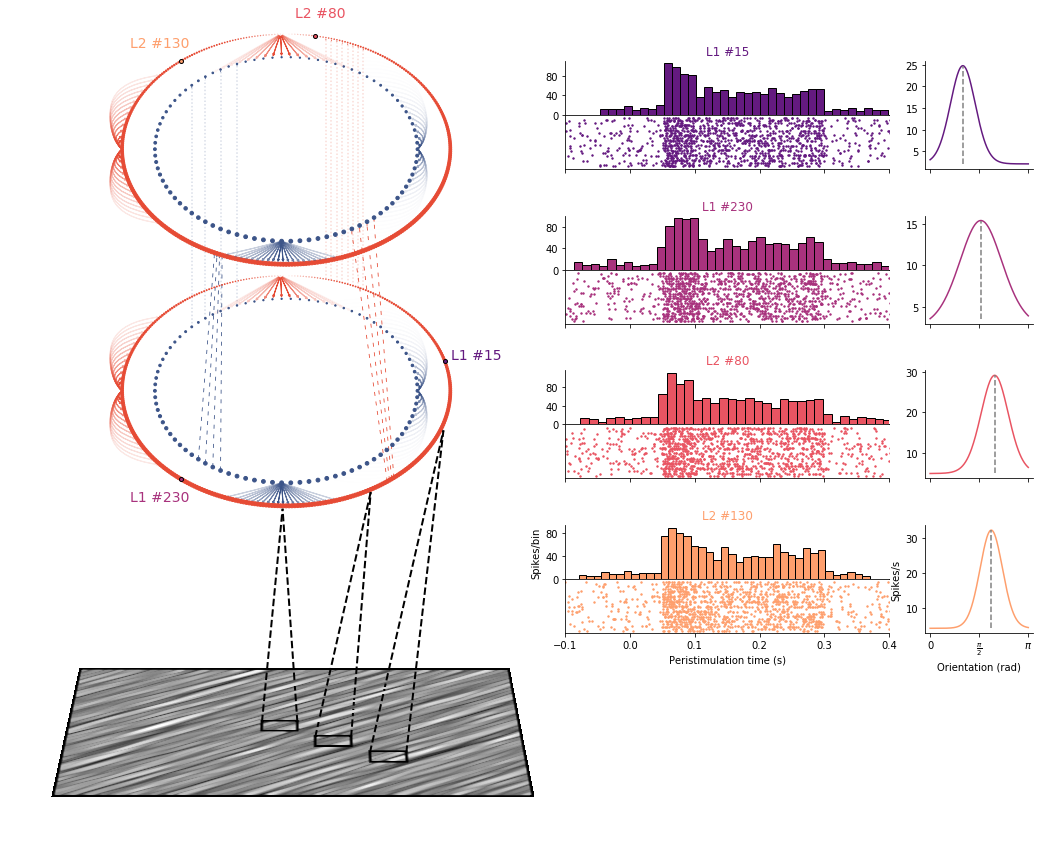

In [11]:
fig = plt.figure(figsize=(10, 15))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])


# Drawing the neural network --------------------------------------
ax = plt.subplot(gs[0])

# Scattering nodes, first layer
ax.scatter(e_xs, e_ys, c=e_color,
           s=s_mult*(-e_ys + np.abs(np.min(e_ys))),
           zorder=500)
ax.scatter(i_xs, i_ys, c=i_color,
           s=s_mult*(-i_ys + np.abs(np.min(e_ys))),
           zorder=500)

# Nodes, second layer
ax.scatter(e_xs, e_ys+2.1, c=e_color,
           s=s_mult * (-e_ys+np.abs(np.min(e_ys)+ring_spacing)))
ax.scatter(i_xs, i_ys+2.1, c=i_color,
           s=s_mult * (-i_ys+np.abs(np.min(e_ys)+ring_spacing)))

## Recurrent connections
# Connect L1 exc-exc nodes
recurrent_connect(idx=180, n_arrows=40, i0_arrows=5, step_arrows=3, color=e_color,
                  xs=e_xs, ys=e_ys, yfrom_rectif = 0., yto_rectif=0.)

# Connect L2 exc-exc nodes
recurrent_connect(idx=180, n_arrows=40, i0_arrows=5, step_arrows=3,color=e_color,
                  xs=e_xs, ys=e_ys, yfrom_rectif = 2.1, yto_rectif=2.1)

# Connect L1 inh-inh nodes
recurrent_connect(idx=0, n_arrows=20, i0_arrows=1, step_arrows=1, color=i_color,
                  xs=i_xs, ys=i_ys, yfrom_rectif = 0., yto_rectif=0.)

# Connect L2 inh-inh nodes
recurrent_connect(idx=0, n_arrows=20, i0_arrows=1, step_arrows=1, color=i_color,
                  xs=i_xs, ys=i_ys, yfrom_rectif = 2.1, yto_rectif=2.1)

## Heterogeneous connections
# Connect L1 exc-inh nodes        
layer_connect(idx=92, n_arrows=8, i0_arrows=1, step_arrows=1, color=e_color,
                xs=e_xs, ys=e_ys, xs2 = i_xs, ys2 = i_ys, mult_connect = .25,
                yfrom_rectif = 0., yto_rectif= 0., do_zero = True)

# Connect L2 exc-inh nodes
layer_connect(idx=92, n_arrows=8, i0_arrows=1, step_arrows=1, color=e_color,
                xs=e_xs, ys=e_ys, xs2 = i_xs, ys2 = i_ys, mult_connect = .25,
                yfrom_rectif = 2.1, yto_rectif= 2.1, do_zero = True)

# Connect L1 inh-exc nodes
layer_connect(idx=67, n_arrows=20, i0_arrows=1, step_arrows=2, color=i_color,
                xs=i_xs, ys=i_ys, xs2 = e_xs, ys2 = e_ys, mult_connect = 4,
                yfrom_rectif = 0., yto_rectif= 0.)

# Connect L2 inh-exc nodes
layer_connect(idx=67, n_arrows=20, i0_arrows=1, step_arrows=2, color=i_color,
                xs=i_xs, ys=i_ys, xs2 = e_xs, ys2 = e_ys, mult_connect = 4,
                yfrom_rectif = 2.1, yto_rectif= 2.108)

## Feedforward connections
# Connect L1 to L2 exc nodes
forward_connect(idx=70, n_arrows=8, step_arrows=2, color=e_color, lw = .3,
                xs=e_xs, ys=e_ys, xs2 = e_xs, ys2 = e_ys, mult_connect = 1,
                add_idx = 0, yto_rectif= 2.075)

# Connect L1 to L2 inh nodes
forward_connect(idx=32, n_arrows=4, step_arrows=2, color=i_color, lw = .3,
                xs=i_xs, ys=i_ys, xs2 = i_xs, ys2 = i_ys, mult_connect = 1,
                add_idx = 0, yto_rectif= 2.075)

# Connect L1 inh to L2 exc nodes
forward_connect(idx=59, n_arrows=2, step_arrows=1, color=i_color, lw = .8,
                xs=i_xs, ys=i_ys, xs2 = e_xs, ys2 = e_ys, mult_connect = 4,
                add_idx = 10, yto_rectif= 2.065)

# Connect L1 exc to L2 inh nodes
forward_connect(idx=310, n_arrows=2, step_arrows=1, color=e_color, lw = .8,
                xs=e_xs, ys=e_ys, xs2 = i_xs, ys2 = i_ys, mult_connect = .25,
                add_idx = 0, yto_rectif= 2.065)


# Drawing the texture  ------------------------------------------
ax2 = plt.subplot(gs[1], projection='3d')

# The texture is displayed as a filled contour
xx, yy = np.meshgrid(np.arange(0, N_X), np.arange(0, N_Y))
im = generate_cloud(np.pi/4, np.pi/36, .1, N_X, N_Y, 42)

# Draw the squares directly on the texture to ensure correct perspective 
s = 20
wx = 2 # height in x axis
wy = 5 # width in y axis
x0s = [109, 139, 169] # bot left origin of the square
ytos = [122, 165, 198] # line destination, in y axis
ztos = [.21, .224, .273] # line destination, in z axis

for i0 in range(len(x0s)) :
    x0 = x0s[i0]
    yto = ytos[i0]
    zto = ztos[i0]
    
    im[x0:x0+s, x0:x0+wy] = 0
    im[x0:x0+wx, x0:x0+s] = 0
    im[x0:x0+s, x0+s:x0+s+wy] = 0
    im[x0+s:x0+s+wx, x0:x0+s+wy] = 0
    
    ax2.plot((x0+5, 126), (x0+.5, yto), (0, zto), clip_on=False, color='k', zorder=100,
         linewidth=2, linestyle='--')
    ax2.plot((x0+5, 126), (x0+20.5, yto), (0, zto), clip_on=False, color='k', zorder=100,
             linewidth=2, linestyle='--')


# Circle the texture with a black square
s = N_X - 2
x0, wx, wy = 0, 2, 4
im[0:s, 0:wy] = 0
im[0:wx, 0:s] = 0
im[0:s, s-2:s+wy] = 0
im[0+s:s+wx, 0:s+wy] = 0

# Plot the MotionClouds on a 3d ax
# thanks Ed Smith ! : https://stackoverflow.com/questions/30464117/plotting-a-imshow-image-in-3d-in-matplotlib
ax2.contourf(xx, yy, im, levels = 125,  offset=0., cmap='gray', zorder=-1)


# Adding the extras axes  ------------------------------------------
for i0 in range(len(plot_idxs)) :
    lab_xs, lab_ys = rad(n_e, e_radius + .2 * e_radius)
    if pops[i0] == 'L2' :
        lab_ys += 2.1
        ax.scatter(e_xs[plot_idxs[i0]], e_ys[plot_idxs[i0]]+2.1,
                   facecolor=cmap[i0], edgecolor = 'k',
                   s=16.,
                   zorder=800)
    else :
        ax.scatter(e_xs[plot_idxs[i0]], e_ys[plot_idxs[i0]],
                   facecolor=cmap[i0], edgecolor = 'k',
                   s=16.,
                   zorder=800)
        
    ax.text(lab_xs[plot_idxs[i0]], lab_ys[plot_idxs[i0]], s = '%s #%d' % (pops[i0],plot_idxs[i0]),
            color = cmap[i0],
           horizontalalignment = 'center', verticalalignment = 'center',
           fontsize = 14)
    
    ## PSTH
    sup_ax1 = fig.add_axes([.9, extra_ys[i0],.45, .05])
    rast = gen_raster(seed0 = 2**i0)
    histo = sup_ax1.hist(np.concatenate(rast),
                         bins = np.linspace(rast[0].min(), rast[0].max(), 40),
                        facecolor = cmap[i0],
                         edgecolor = 'k')

    sup_ax1.set_title('%s #%d' % (pops[i0],plot_idxs[i0]), color = cmap[i0])
    sup_ax1.set_xticks([])
    sup_ax1.set_yticks([0, 40, 80])
    sup_ax1.spines['right'].set_visible(False)
    sup_ax1.spines['top'].set_visible(False)
    sup_ax1.set_xlim(-.1, .4)
    
    ## Rasterplot
    sup_ax2 = fig.add_axes([.9,  extra_ys[i0]-.05, .45, .05])
    for i1, trial in enumerate(rast) :
        sup_ax2.scatter(trial, np.full_like(trial, i1),
                        facecolor = cmap[i0], s = 2)
    
    sup_ax2.set_yticks([])
    sup_ax2.spines['right'].set_visible(False)
    sup_ax2.set_xlim(-.1, .4)
    
    ## Tuning curve
    sup_ax3 = fig.add_axes([.9+.5,  extra_ys[i0]-.05,.15, .1])
    tc = gen_tc(seed = 2**i0)
    xs = np.linspace(0, np.pi, 200)
    sup_ax3.plot(xs, tc,
                color = cmap[i0])
    sup_ax3.plot([xs[np.argmax(tc)], xs[np.argmax(tc)]],
                 [np.min(tc), np.max(tc)],
                    color = 'gray', linestyle = '--')
    
    sup_ax3.set_xticks([0, np.pi/2, np.pi])
    sup_ax3.set_xticklabels([0, r'$\frac{\pi}{%.0f}$' % 2, r'$\pi$'])
    sup_ax3.spines['right'].set_visible(False)
    sup_ax3.spines['top'].set_visible(False)
    
    if i0 == len(plot_idxs) - 1 :
        sup_ax1.set_ylabel('Spikes/bin')
        sup_ax2.set_xlabel('Peristimulation time (s)')
        sup_ax3.set_ylabel('Spikes/s')
        sup_ax3.set_xlabel('Orientation (rad)')
    else :
        sup_ax2.set_xticklabels([])
        sup_ax3.set_xticklabels([])

# Setting up the plot  ------------------------------------------
ax.set_xlim(-1.7, 1.7)
ax.set_ylim(-1.05, 3.15)
ax.axis('off')

ax2.set_zlim(-.08, .1)
ax2.view_init(elev=40, azim=.2)
ax2.dist = 6.
ax2.axis('off')

plt.subplots_adjust(hspace=.25)
plt.show()

if save :
    fig.savefig('figure.pdf', format='pdf', bbox_inches='tight', dpi = dpi)
    fig.savefig('figure.png', format='png', bbox_inches='tight', dpi = dpi)